# Setup

In [56]:
import cv2
import numpy as np

from skimage import data, exposure
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [2]:
bf_path = "R:/Users/Rahul/Documents/494/Data/88hr timelapse/EGFP_1mm/BF/"
tr_path = "R:/Users/Rahul/Documents/494/Data/88hr timelapse/EGFP_1mm/Texas Red/"

day_0 = "R:/Users/Rahul/Documents/494/Data/Day 0/1mm EGFP/"
sample_img = "1mmEGFP_Day0_Plate_R_p00_0_A02f01d4.TIF"

sample_spheroid = "R:/Users/Rahul/Documents/494/Data/88hr timelapse/EGFP_1mm/BF/scan_Plate_R_p00_0_A02f00d4.TIF"
sample_sensor = "R:/Users/Rahul/Documents/494/Data/88hr timelapse/EGFP_1mm/Texas Red/scan_Plate_R_p00_0_A02f00d3.TIF"

In [ ]:
print_img(day_0 + sample_img)

## Helper Functions

In [3]:
def preprocess_img(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # Normalize image
    min_bit = np.min(image)
    max_bit = np.max(image)
    image = cv2.normalize(image*16, dst=None, alpha=min_bit*16, beta=max_bit*16, norm_type=cv2.NORM_MINMAX)
    return image

def print_img(preprocessed_img, title="Image"):    
    fig, ax = plt.subplots(figsize=(9, 3))
    ax.set_title(title)
    ax.imshow(preprocessed_img, cmap=plt.cm.gray)
    
def map_uint16_to_uint8(img, lower_bound=None, upper_bound=None):
    '''
    Map a 16-bit image trough a lookup table to convert it to 8-bit.

    Parameters
    ----------
    img: numpy.ndarray[np.uint16]
        image that should be mapped
    lower_bound: int, optional
        lower bound of the range that should be mapped to ``[0, 255]``,
        value must be in the range ``[0, 65535]`` and smaller than `upper_bound`
        (defaults to ``numpy.min(img)``)
    upper_bound: int, optional
       upper bound of the range that should be mapped to ``[0, 255]``,
       value must be in the range ``[0, 65535]`` and larger than `lower_bound`
       (defaults to ``numpy.max(img)``)

    Returns
    -------
    numpy.ndarray[uint8]
    '''
    if not(0 <= lower_bound < 2**16) and lower_bound is not None:
        raise ValueError(
            '"lower_bound" must be in the range [0, 65535]')
    if not(0 <= upper_bound < 2**16) and upper_bound is not None:
        raise ValueError(
            '"upper_bound" must be in the range [0, 65535]')
    if lower_bound is None:
        lower_bound = np.min(img)
    if upper_bound is None:
        upper_bound = np.max(img)
    if lower_bound >= upper_bound:
        raise ValueError(
            '"lower_bound" must be smaller than "upper_bound"')
    lut = np.concatenate([
        np.zeros(lower_bound, dtype=np.uint16),
        np.linspace(0, 255, upper_bound - lower_bound).astype(np.uint16),
        np.ones(2**16 - upper_bound, dtype=np.uint16) * 255
    ])
    return lut[img].astype(np.uint8)

def scale_print(img_arr):
    cv2.namedWindow("output", cv2.WINDOW_NORMAL)   
    
    min_bit = np.min(img_arr)
    max_bit = np.max(img_arr)

    img_scaled = cv2.normalize(img_arr*16, dst=None, alpha=min_bit*16, beta=max_bit*16, norm_type=cv2.NORM_MINMAX)    
    
    cv2.imshow("output",img_scaled)
    cv2.waitKey(0)
    cv2.destroyAllWindows()    

# Tested Strategies

## OpenCV HoughCircles

In [116]:
def filter_circles(img, circles, threshold = 100):
    circles = circles[0]

    new_circles = []
    for i in range(len(circles)):
        circle = circles[i]
        brightness = img[int(circle[1])][int(circle[0])]

        if brightness < threshold:
            new_circles.append(circle)
            
    return new_circles

In [117]:
img = preprocess_img(sample_spheroid)
_, thresh = cv2.threshold(img, 100, np.max(img), cv2.THRESH_BINARY)

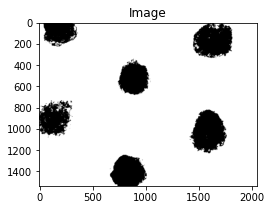

In [120]:
print_img(thresh)

In [125]:
circles = cv2.HoughCircles(thresh,cv2.HOUGH_GRADIENT,1,minDist=500,
                            param1=50,param2=30,minRadius=50,maxRadius=1000)

circles = filter_circles(thresh, circles)

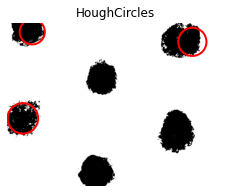

In [126]:
fig, ax = plt.subplots(figsize=(9, 3))

ax.set_title("HoughCircles")
ax.imshow(thresh, cmap=plt.cm.gray)

for circle in circles:
    x, y, r = circle[0], circle[1], circle[2]
    c = plt.Circle((x, y), r, color="red", linewidth=2, fill=False)
    ax.add_patch(c)
    
ax.set_axis_off()

## OpenCV Find Countours

### Fitting circles

In [100]:
threshold = 100

pp_img = preprocess_img(sample_sensor)
# pp_img = preprocess_img(sample_spheroid)

_, thresh = cv2.threshold(pp_img, threshold, np.max(pp_img), cv2.THRESH_BINARY)

In [ ]:
print_img(thresh)

In [107]:
raw_contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, 
                                       cv2.CHAIN_APPROX_NONE)

In [ ]:
# Spheroids
# min_radius = 100
# max_radius = 1000

# Sensors
min_radius = 10
max_radius = 100

contours = []
for contour in raw_contours:
    # Most items in raw contours are lines or small shapes
    if cv2.contourArea(contour) < (np.pi * min_radius ** 2):
        continue
    contours.append(contour)

circle_coords = []
for contour in contours:
    (x, y), r = cv2.minEnclosingCircle(contour)
    if r > max_radius:
        continue
    circle_coords.append((x, y, r))

In [ ]:
verbose = True

fig, ax = plt.subplots(figsize=(9, 3))

ax.set_title("MinEnclosingCircle")
ax.imshow(pp_img, cmap=plt.cm.gray)

for idx, circle in enumerate(circle_coords):
    x, y, r = circle[0], circle[1], circle[2]
    c = plt.Circle((x, y), r, color="red", linewidth=2, fill=False)
    
    if verbose: 
        scale = 0.638
        x, y, r = x/scale, y/scale, r/scale        
        
        ax.text(x + r, y, str(idx+1), color='red', fontsize=15)
        print("Circle #{}:\n center (x,y): ({}, {})\n radius: {}".format(idx+1,x,y,r))
        
    ax.add_patch(c)
    
ax.set_axis_off()

In [ ]:
print_img(preprocess_img(sample_spheroid))

### Fitting ellipses

In [15]:
sample_sensor = tr_path + "scan_Plate_R_p20_0_A02f00d3.TIF"

threshold = 100

pp_img = preprocess_img(sample_sensor)
# pp_img = preprocess_img(sample_spheroid)

_, thresh = cv2.threshold(pp_img, threshold, np.max(pp_img), cv2.THRESH_BINARY)

In [19]:
raw_contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, 
                                       cv2.CHAIN_APPROX_NONE)

In [48]:
# Spheroids
# min_radius = 100
# max_radius = 1000

# Sensors
min_radius = 10
max_radius = 100

contours = []
for contour in raw_contours:
    # Most items in raw contours are lines or small shapes
    if cv2.contourArea(contour) < (np.pi * min_radius ** 2):
        continue
    contours.append(contour)

ellipse_coords = []
for contour in contours:
    (x,y),(w,h),ang = cv2.fitEllipse(contour)
    if max(w,h) > max_radius:
        continue
    ellipse_coords.append(((x,y),(w,h),ang))

In [ ]:
verbose = True

fig, ax = plt.subplots(figsize=(9, 3))

ax.set_title("FitEllipse")
ax.imshow(pp_img, cmap=plt.cm.gray)

for idx, ellipse in enumerate(ellipse_coords):
    (x,y), (w,h), ang = ellipse
    
    e = Ellipse((x,y), w, h, ang, color="red", linewidth=2, fill=False)
    
    if verbose: 
        ax.text(x + w, y, str(idx+1), color='red', fontsize=15)
        
        scale = 0.638
        x, y, w, h = x/scale, y/scale, w/scale, h/scale        
        print("Ellipse #{}:\n center (x,y): ({}, {})\n major: {}, minor: {}, angle: {}".format(idx+1,x,y,max(w,h),min(w,h),ang))
        
    ax.add_patch(e)
    
ax.set_axis_off()

## OpenCV SimpleBlobDetector

In [ ]:
img = cv2.imread((day_0 + sample_img), cv2.IMREAD_GRAYSCALE)
detector = cv2.SimpleBlobDetector()

# detector.detect(img) always kills the kernel
keypoints = detector.detect(img)

im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
# Show keypoints
cv2.imshow("Keypoints", im_with_keypoints)
cv2.waitKey(0)

## Scikit-Images

In [ ]:
image = cv2.imread(day_0 + sample_img, cv2.IMREAD_GRAYSCALE)

In [ ]:
# Normalize image
min_bit = np.min(image)
max_bit = np.max(image)

image = cv2.normalize(image*16, dst=None, alpha=min_bit*16, beta=max_bit*16, norm_type=cv2.NORM_MINMAX)

### Laplacian of Gaussian (LoG)

In [ ]:
# Threshold --> Intensity threshold. More blobs detected as it decreases.
# Min_Sigma --> The minimum standard deviation for Gaussian kernel. Keep this low to detect smaller blobs.
# Max_Sigma --> The maximum standard deviation for Gaussian kernel. Keep this high to detect larger blobs.

blobs_log = blob_log(image, min_sigma=200, max_sigma=250, num_sigma=10, threshold=10)
# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 3))

ax.set_title("Laplacian of Gaussian")
ax.imshow(image,cmap=plt.cm.gray)

for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color="red", linewidth=2, fill=False)
    ax.add_patch(c)
    
ax.set_axis_off()

### Determinant of Hessian (DoH)

In [ ]:
blobs_doh = blob_doh(image, max_sigma=500, threshold=0.01)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 3))

ax.set_title("Determinant of Hessiana")
ax.imshow(image, cmap=plt.cm.gray)

for blob in blobs_doh:
    y, x, r = blob
    c = plt.Circle((x, y), r, color="red", linewidth=2, fill=False)
    ax.add_patch(c)
    
ax.set_axis_off()

## PyQT 

In [ ]:
import sys
try:
    from PyQt5.QtCore import Qt, QT_VERSION_STR
    from PyQt5.QtGui import QImage
    from PyQt5.QtWidgets import QApplication, QFileDialog
except ImportError:
    try:
        from PyQt4.QtCore import Qt, QT_VERSION_STR
        from PyQt4.QtGui import QImage, QApplication, QFileDialog
    except ImportError:
        raise ImportError("Requires PyQt5 or PyQt4.")
from QtImageViewer import QtImageViewer


# Custom slot for handling mouse clicks in our viewer.
# Just prints the (row, column) matrix index of the 
# image pixel that was clicked on.
def handleLeftClick(x, y):
    row = int(y)
    column = int(x)
    print("Pixel (row="+str(row)+", column="+str(column)+")")
    

if __name__ == '__main__':
    # Create the QApplication.
    app = QApplication(sys.argv)
        
    # Create an image viewer widget.
    viewer = QtImageViewer()
        
    # Set viewer's aspect ratio mode.
    # !!! ONLY applies to full image view.
    # !!! Aspect ratio always ignored when zoomed.
    #   Qt.IgnoreAspectRatio: Fit to viewport.
    #   Qt.KeepAspectRatio: Fit in viewport using aspect ratio.
    #   Qt.KeepAspectRatioByExpanding: Fill viewport using aspect ratio.
    viewer.aspectRatioMode = Qt.KeepAspectRatio
    
    # Set the viewer's scroll bar behaviour.
    #   Qt.ScrollBarAlwaysOff: Never show scroll bar.
    #   Qt.ScrollBarAlwaysOn: Always show scroll bar.
    #   Qt.ScrollBarAsNeeded: Show scroll bar only when zoomed.
    viewer.setHorizontalScrollBarPolicy(Qt.ScrollBarAsNeeded)
    viewer.setVerticalScrollBarPolicy(Qt.ScrollBarAsNeeded)
    
    # Allow zooming with right mouse button.
    # Drag for zoom box, doubleclick to view full image.
    viewer.canZoom = True
    
    # Allow panning with left mouse button.
    viewer.canPan = True
        
    # Load an image to be displayed.
    if QT_VERSION_STR[0] == '4':
        fileName = QFileDialog.getOpenFileName(None, "Open image file...")
    elif QT_VERSION_STR[0] == '5':
        fileName, dummy = QFileDialog.getOpenFileName(None, "Open image file...")
    image = QImage(fileName)
    
    # Display the image in the viewer.
    viewer.setImage(image)
    
    # Handle left mouse clicks with your own custom slot
    # handleLeftClick(x, y). (x, y) are image coordinates.
    # For (row, col) matrix indexing, row=y and col=x.
    # ImageViewerQt also provides similar signals for
    # left/right mouse button press, release and doubleclick.
    viewer.leftMouseButtonPressed.connect(handleLeftClick)
        
    # Show the viewer and run the application.
    viewer.show()
    sys.exit(app.exec_())